## Analysis of the Sample of the French Comedies

We will examine the 10% proportionate stratified random sample of the French 5-act verse comedies (29 comedies from different decades). We will create visualizatios of the features, and, on the basis of these visualizations, pose a hypothesis about periodization of these comedies.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec

In [2]:
sample_df = pd.read_csv('../French_Comedies/Data/French_Comedies_Data_Sample.csv')

In [3]:
sample_df.head()

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,...,percentage_above_two_speakers,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades
0,F_51,Les Apparences trompeuses,Boisrobert,François Le Métel de,1655,0,5,NaN,12,45,...,43.18,6.288,1.002,7,15.909,NaN,NaN,NaN,1655,1660
1,F_54,Le Marquis ridicule,Scarron,Paul,1656,0,5,http://www.theatre-classique.fr/pages/document...,10,24,...,43.24,22.387,1.692,3,8.108,637.0,1654.0,0.385,1660,1660
2,F_212,La Belle-mère ou les Dangers d'un second mariage,Vigée,Louis-Jean-Baptiste-Étienne,1788,0,5,NaN,10,42,...,16.67,4.167,0.950,5,11.905,NaN,NaN,NaN,1790,1790
3,F_206,L'École des pères,Pieyre,Alexandre,1787,0,5,NaN,9,63,...,13.64,10.606,0.785,2,3.030,NaN,NaN,NaN,1790,1790
4,F_266,Le Faux bonhomme,Duval,Alexandre,1821,0,5,NaN,8,42,...,26.67,6.481,1.134,0,0.000,NaN,NaN,NaN,1825,1830


In [4]:
sample_df.shape

(29, 25)

# Part I. Visualizations

## I. Number of Dramatic Characters who Appear on Stage
We will create a scatterplot of the number of dramatic characters by the year of creation joint with the kernel desnity plot.

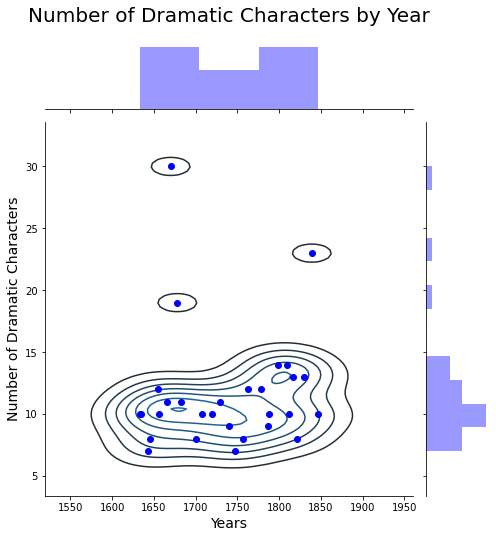

In [5]:
sns.jointplot('date', 
              'num_present_characters',
               data=sample_df, 
               color='b', 
               height=7).plot_joint(
               sns.kdeplot, 
               zorder=0, 
               n_levels=7)
plt.title('Number of Dramatic Characters by Year', fontsize=20, pad=100)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Number of Dramatic Characters', fontsize=14)

plt.show()

Based on the plot, we notice that there are potential outliers right before 1700 and around 1850. However, we are dealing with the sample. In the entire dataset, datapoints in this range, i.e., with the number of dramatic characters above 20 may be more numerous. 

## II. Mobility Coefficient

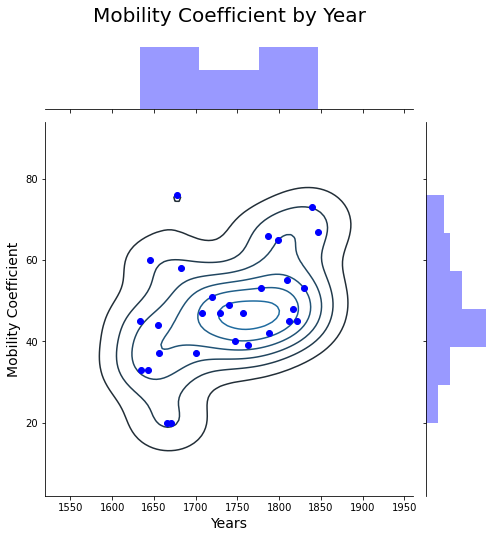

In [6]:
sns.jointplot('date', 
              'num_scenes_iarkho',
               data=sample_df, 
               color='b', 
               height=7).plot_joint(
               sns.kdeplot, 
               zorder=0, 
               n_levels=7)
plt.title('Mobility Coefficient by Year', fontsize=20, pad=100)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Mobility Coefficient', fontsize=14)
plt.show()

Mobility coefficient reveals an upward trend. Two groups with high variance emerge: one ending around 1700 and the other beginning at the end of the 1700s. The period in between displays lower variance.

## III. Standard Range of the Speaking Characters (Sigma)

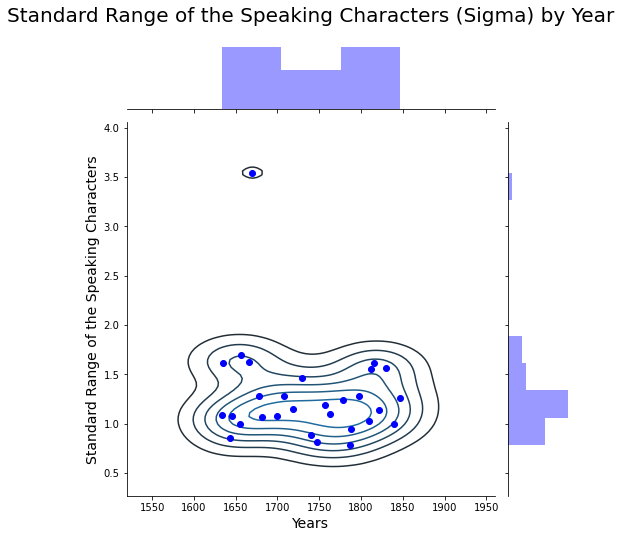

In [7]:
sns.jointplot('date', 'sigma_iarkho',
                   data=sample_df, color="b", height=7).plot_joint(sns.kdeplot, zorder=0, n_levels=7)
plt.title('Standard Range of the Speaking Characters (Sigma) by Year', fontsize=20, pad=100)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Standard Range of the Speaking Characters', fontsize=14)
plt.show()

Based on this visualization, we can tell that sigma also falls into two groups separated by the period with a relatively  lower range of dispersion. 

## IV. Percentage of Non-Dialogues

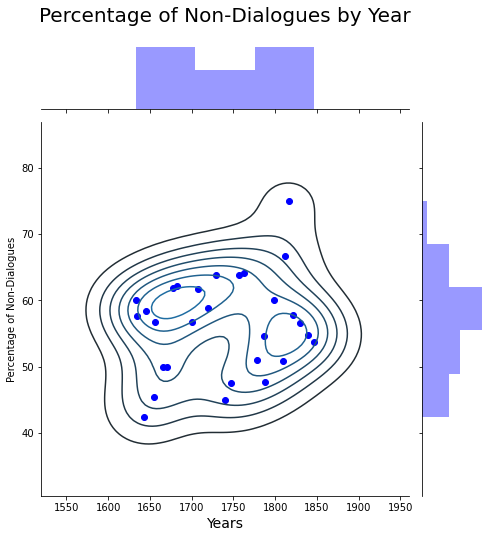

In [8]:
sns.jointplot('date', 
              'percentage_non_duologues',
               data=sample_df, 
               color='b', 
               height=7).plot_joint(
               sns.kdeplot, 
               n_levels=7)
plt.title('Percentage of Non-Dialogues by Year', fontsize=20, pad=100)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage of Non-Dialogues')
plt.show()

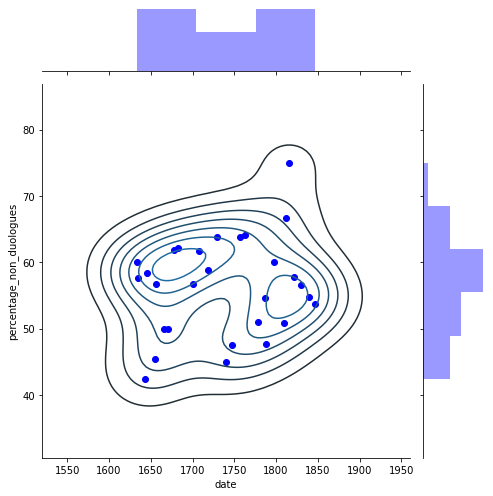

In [9]:
g = sns.jointplot('date', 
              'percentage_non_duologues',
               data=sample_df, 
               color='b', 
               height=7).plot_joint(
               sns.kdeplot, 
               n_levels=7)

We cannot say anything definitive from this plot: the percentage of non-dialogues seems stable over time. However, we anticipate that this could be in part due to the fact that non-dialogues include both monologues and polylogues. Therefore, it becomes necessary to examine the evolution of these speech types to see if they reveal similar or divergent trends over time.

## Non-Dialogues, Monologues, and Polylogues

In [10]:
sorted_sample = sample_df.sort_values(by='date')

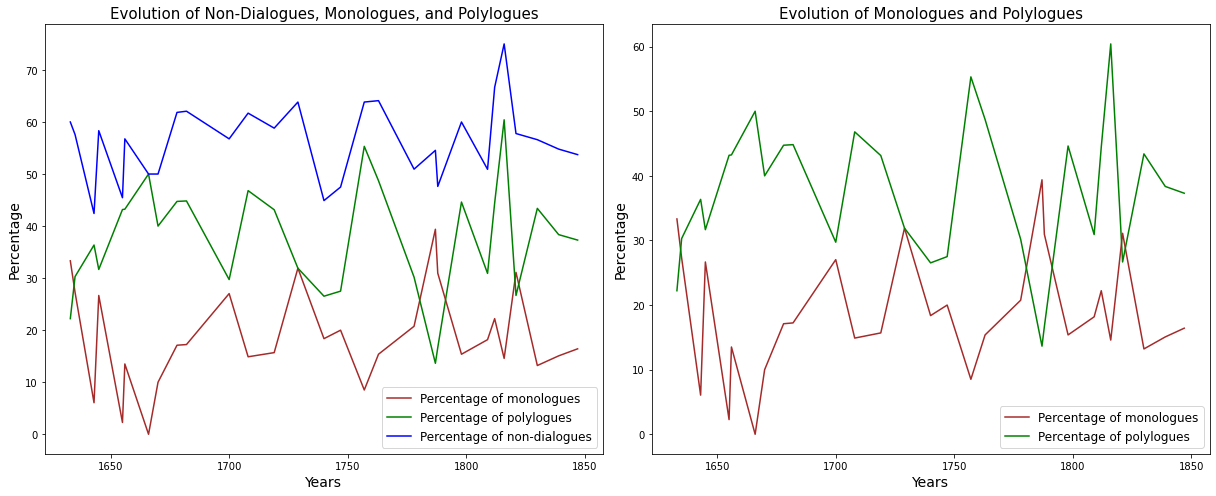

In [11]:
plt.figure(figsize=(17, 7))
plt.subplot(121)
plt.title('Evolution of Non-Dialogues, Monologues, and Polylogues', fontsize=15)
plt.plot(sorted_sample['date'], sorted_sample['percentage_monologues'], color='brown', label='Percentage of monologues')
plt.plot(sorted_sample['date'], sorted_sample['percentage_above_two_speakers'], color='green', label='Percentage of polylogues')
plt.plot(sorted_sample['date'], sorted_sample['percentage_non_duologues'], color='b', label='Percentage of non-dialogues')
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

plt.subplot(122)
plt.title('Evolution of Monologues and Polylogues', fontsize=15)
plt.plot(sorted_sample['date'], sorted_sample['percentage_monologues'], color='brown', label='Percentage of monologues')
plt.plot(sorted_sample['date'], sorted_sample['percentage_above_two_speakers'], color='green', label='Percentage of polylogues')
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.tight_layout()
plt.show()

If we plot the percentage of non-dialogues, monologues, and polylogues together, we will notice that, for comedies, it is unreasonable to group polylogues and monologues together. In fact, their development is reversed: increase in the percentage of monologues is accompanied by a drop in the number of polylogues and vice verse. It will be useful to see if these two features are correlated.

In [12]:
sorted_sample[['percentage_above_two_speakers', 'percentage_monologues']].corr()

,percentage_above_two_speakers,percentage_monologues
percentage_above_two_speakers,1.000000,-0.748575
percentage_monologues,-0.748575,1.000000


It turns out that the percentage of monologues and the percentage of polylogues have a rather strong negative correlations ≈ -0.75.

## V. Percentage of Polylogues

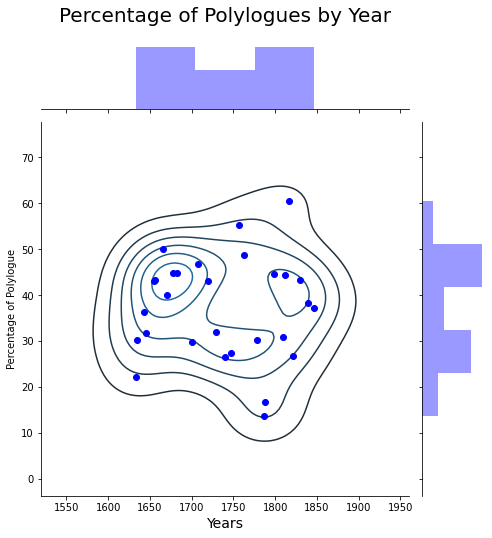

In [13]:
sns.jointplot('date', 'percentage_above_two_speakers',
                   data=sample_df, color="b", height=7).plot_joint(sns.kdeplot, zorder=0, n_levels=7)
plt.title('Percentage of Polylogues by Year', fontsize=20, pad=100)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage of Polylogue')

plt.show()

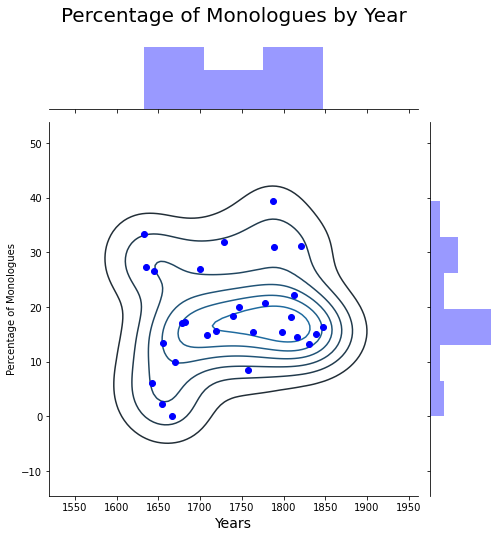

In [14]:
sns.jointplot('date', 'percentage_monologues',
                   data=sample_df, color="b", height=7).plot_joint(sns.kdeplot, zorder=0, n_levels=7)
plt.title('Percentage of Monologues by Year', fontsize=20, pad=100)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Percentage of Monologues')

plt.show()

## The Boundaries

The percentage of monologues reveals a similar trend to other features: two periods with high variance separated by a period of relatively low variance. The percentage of monologues also seems to grow over time. The first boundary falls around year 1700, however, the second boundary is somewhat vague: it falls somewhere in late 1700s. A reasonable guess would be to connect the boundary with historical events in France, i.e. the French Revolution (1789). 

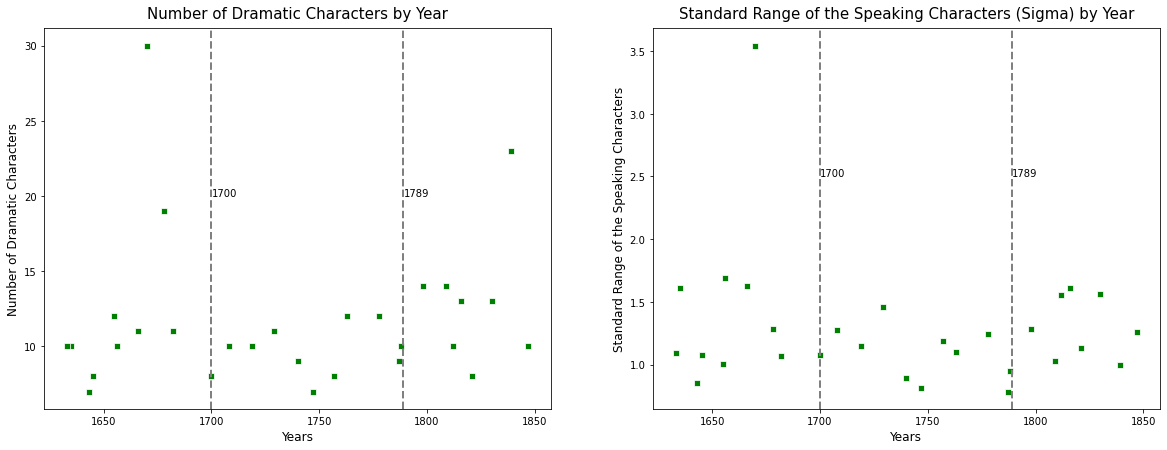

In [15]:
plt.figure(figsize=(20, 7))
plt.subplot(121)
plt.title('Number of Dramatic Characters by Year', fontsize=15, pad=10)
sns.scatterplot('date', 'num_present_characters', data=sample_df, color='g', marker='s')
plt.axvline(1700, color='grey',linestyle='dashed', linewidth=2)
plt.text(1700.1,20,'1700')
plt.axvline(1789, color='grey',linestyle='dashed', linewidth=2)
plt.text(1789.1,20,'1789')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Number of Dramatic Characters', fontsize=12)

plt.subplot(122)
plt.title('Standard Range of the Speaking Characters (Sigma) by Year', fontsize=15, pad=10)
sns.scatterplot('date', 'sigma_iarkho', data=sample_df, color='g', marker='s')
plt.axvline(1700, color='grey',linestyle='dashed', linewidth=2)
plt.text(1700.1,2.5,'1700')
plt.axvline(1789, color='grey',linestyle='dashed', linewidth=2)
plt.text(1789.1,2.5,'1789')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Standard Range of the Speaking Characters', fontsize=12)

plt.show()


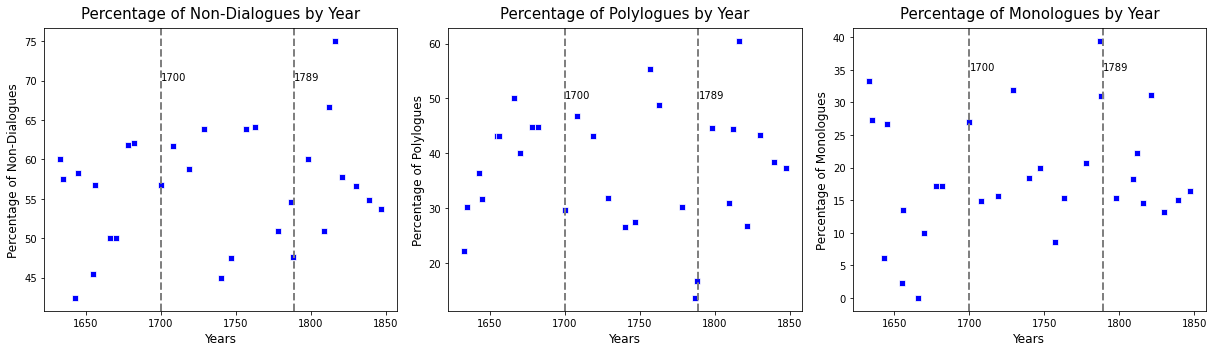

In [16]:
plt.figure(figsize=(17, 5))
plt.subplot(131)
plt.title('Percentage of Non-Dialogues by Year', fontsize=15, pad=10)
sns.scatterplot('date', 'percentage_non_duologues', data=sample_df, color='b', marker='s')
plt.axvline(1700, color='grey',linestyle='dashed', linewidth=2)
plt.text(1700.1, 70,'1700')
plt.axvline(1789, color='grey',linestyle='dashed', linewidth=2)
plt.text(1789.1, 70,'1789')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Percentage of Non-Dialogues', fontsize=12)

plt.subplot(132)
plt.title('Percentage of Polylogues by Year', fontsize=15, pad=10)
sns.scatterplot('date', 'percentage_above_two_speakers', data=sample_df, color='b', marker='s')
plt.axvline(1700, color='grey',linestyle='dashed', linewidth=2)
plt.text(1700.1, 50,'1700')
plt.axvline(1789, color='grey',linestyle='dashed', linewidth=2)
plt.text(1789.1, 50,'1789')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Percentage of Polylogues', fontsize=12)

plt.subplot(133)
plt.title('Percentage of Monologues by Year', fontsize=15, pad=10)
sns.scatterplot('date', 'percentage_monologues', data=sample_df, color='b', marker='s')
plt.axvline(1700, color='grey',linestyle='dashed', linewidth=2)
plt.text(1700.1, 35,'1700')
plt.axvline(1789, color='grey',linestyle='dashed', linewidth=2)
plt.xlabel('Years', fontsize=12)
plt.text(1789.1, 35,'1789')
plt.ylabel('Percentage of Monologues', fontsize=12)
plt.tight_layout()
plt.show()

## Periodization:

While 1789 seems to be a reasonable boundary for sigma and the number of dramatic characters, it does not completely work for the percentag of polylogues and monologues: an earlier date appears to be more appropriate. Therefore, we will select **1785** as the upper boundary.

Our three periods will be:
1. From 1629 to 1700
2. From 1700 to 1785
3. From 1785 to 1847

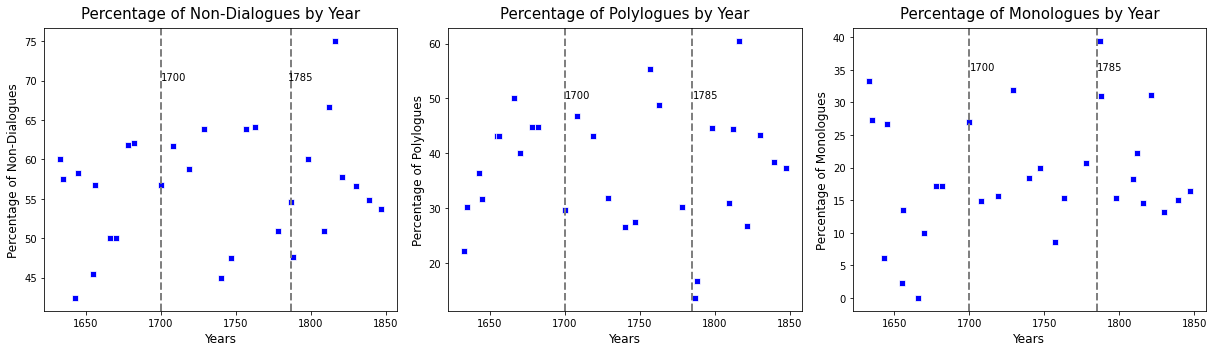

In [17]:
plt.figure(figsize=(17, 5))
plt.subplot(131)
plt.title('Percentage of Non-Dialogues by Year', fontsize=15, pad=10)
sns.scatterplot('date', 'percentage_non_duologues', data=sample_df, color='b', marker='s')
plt.axvline(1700, color='grey',linestyle='dashed', linewidth=2)
plt.text(1700.1, 70,'1700')
plt.axvline(1787, color='grey',linestyle='dashed', linewidth=2)
plt.text(1785.1, 70,'1785')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Percentage of Non-Dialogues', fontsize=12)

plt.subplot(132)
plt.title('Percentage of Polylogues by Year', fontsize=15, pad=10)
sns.scatterplot('date', 'percentage_above_two_speakers', data=sample_df, color='b', marker='s')
plt.axvline(1700, color='grey',linestyle='dashed', linewidth=2)
plt.text(1700.1, 50,'1700')
plt.axvline(1785, color='grey',linestyle='dashed', linewidth=2)
plt.text(1785.1, 50,'1785')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Percentage of Polylogues', fontsize=12)

plt.subplot(133)
plt.title('Percentage of Monologues by Year', fontsize=15, pad=10)
sns.scatterplot('date', 'percentage_monologues', data=sample_df, color='b', marker='s')
plt.axvline(1700, color='grey',linestyle='dashed', linewidth=2)
plt.text(1700.1, 35,'1700')
plt.axvline(1785, color='grey',linestyle='dashed', linewidth=2)
plt.xlabel('Years', fontsize=12)
plt.text(1785.1, 35,'1785')
plt.ylabel('Percentage of Monologues', fontsize=12)
plt.tight_layout()
plt.show()

We will update this boundary for the number of dramatic characters and sigma.

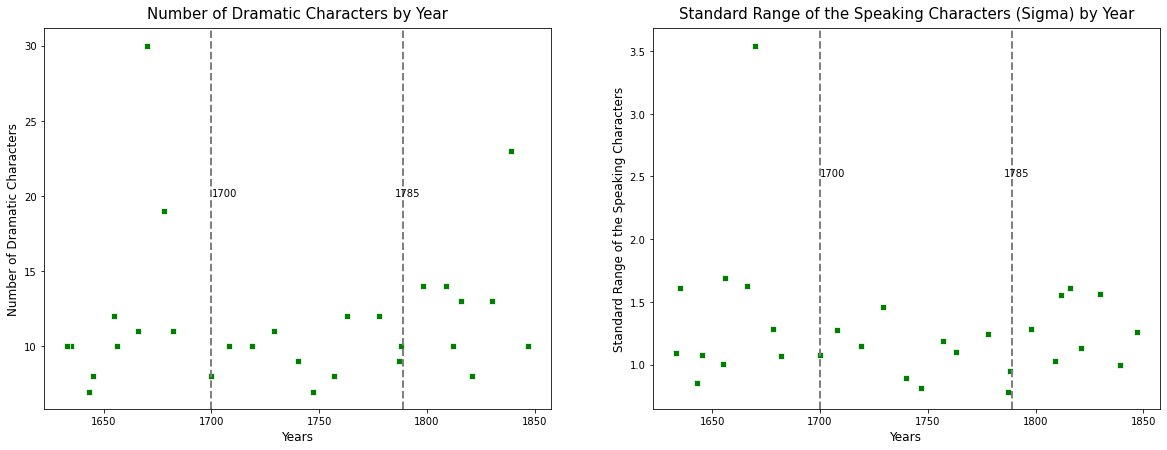

In [18]:
plt.figure(figsize=(20, 7))
plt.subplot(121)
plt.title('Number of Dramatic Characters by Year', fontsize=15, pad=10)
sns.scatterplot('date', 'num_present_characters', data=sample_df, color='g', marker='s')
plt.axvline(1700, color='grey',linestyle='dashed', linewidth=2)
plt.text(1700.1,20,'1700')
plt.axvline(1789, color='grey',linestyle='dashed', linewidth=2)
plt.text(1785.1,20,'1785')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Number of Dramatic Characters', fontsize=12)

plt.subplot(122)
plt.title('Standard Range of the Speaking Characters (Sigma) by Year', fontsize=15, pad=10)
sns.scatterplot('date', 'sigma_iarkho', data=sample_df, color='g', marker='s')
plt.axvline(1700, color='grey',linestyle='dashed', linewidth=2)
plt.text(1700.1,2.5,'1700')
plt.axvline(1789, color='grey',linestyle='dashed', linewidth=2)
plt.text(1785.1,2.5,'1785')
plt.xlabel('Years', fontsize=12)
plt.ylabel('Standard Range of the Speaking Characters', fontsize=12)

plt.show()


In [19]:
def determine_period(row):
    if row <= 1700:
        period = 1
    elif row > 1700 and row < 1785:
        period = 2
    else:
        period = 3
    
    return period

In [20]:
sorted_sample['period'] = sorted_sample['date'].apply(determine_period)

In [21]:
period_one = sorted_sample[sorted_sample.period == 1].copy()
period_two = sorted_sample[sorted_sample.period == 2].copy()
period_three = sorted_sample[sorted_sample.period == 3].copy()

# Part II. Descriptive Statistics by Periods (Based on the Sample)

## Period One (1629 - 1700)

In [22]:
period_one.describe().loc[
                        ['mean', 'std', 'min', 'max'], 
                        ['num_present_characters', 
                        'num_scenes_iarkho',
                        'sigma_iarkho']]

,num_present_characters,num_scenes_iarkho,sigma_iarkho
mean,12.363636,42.090909,1.448364
std,6.652409,17.114056,0.750233
min,7.000000,20.000000,0.856000
max,30.000000,76.000000,3.543000


## Period Two (1700 - 1785)

In [23]:
period_two.describe().loc[
                        ['mean', 'std', 'min', 'max'], 
                        ['num_present_characters', 
                        'num_scenes_iarkho',
                        'sigma_iarkho']]

,num_present_characters,num_scenes_iarkho,sigma_iarkho
mean,9.875000,46.625000,1.138250
std,1.807722,4.897157,0.208771
min,7.000000,39.000000,0.812000
max,12.000000,53.000000,1.460000


## Period Three (1785 - 1847)

In [24]:
period_three.describe().loc[
                            ['mean', 'std', 'min', 'max'], 
                            ['num_present_characters', 
                            'num_scenes_iarkho',
                            'sigma_iarkho']]

,num_present_characters,num_scenes_iarkho,sigma_iarkho
mean,12.400000,55.900000,1.217000
std,4.299871,11.069979,0.286714
min,8.000000,42.000000,0.785000
max,23.000000,73.000000,1.610000


### The Number of Dramatic Characters
The mean number of dramatic characters was high during period one was 12.36, with the high standard deviation of 6.65). During period two, the mean number of dramatic characters dropped to 8.59 with the lower standard deviation of 1.80. During period three, the mean number of dramatic characters increased to 12.4 and its standard deviation also increased (4.3). The Min-Max range for period one was 7 to 30, for period two - 7 to 12, and for three - approx. 8 to 23.

### Mobility Coefficient
The mean mobility coefficient gradually increased over time: from 42.09 in period one, to 46.63 in period two, and 55.9 in period three. However, the standard deviation was high in period one and three, 17.11 and 11.07, respectively, and low in period two - 4.9. The Min-Max range for period one was 20 to 70, in period two - 39 to 53, and in perid three - 42 to 73.

### The Standard Range of the Number of Speaking Characters (Sigma)
The mean standard range in period one was 1.138, in period two - 1.13, and in period three - 1.21. The Min-Max range for period one was 0.85 to 3.54, in period two - 0.81 to 1.46, and in period three - 0.78 to 1.61.


In [25]:
period_one.describe().loc[
                        ['mean', 'std', 'min', 'max'], 
                        ['percentage_non_duologues',
                         'percentage_monologues',
                         'percentage_above_two_speakers']]

,percentage_non_duologues,percentage_monologues,percentage_above_two_speakers
mean,54.655455,16.408182,37.842727
std,6.662312,11.177232,8.447155
min,42.420000,0.000000,22.220000
max,62.070000,33.330000,50.000000


In [26]:
period_two.describe().loc[
                        ['mean', 'std', 'min', 'max'], 
                        ['percentage_non_duologues',
                         'percentage_monologues',
                        'percentage_above_two_speakers']]

,percentage_non_duologues,percentage_monologues,percentage_above_two_speakers
mean,56.952500,18.187500,38.76500
std,7.950523,6.727756,11.04633
min,44.900000,8.510000,26.53000
max,64.100000,31.910000,55.32000


In [27]:
period_three.describe().loc[
                        ['mean', 'std', 'min', 'max'], 
                        ['percentage_non_duologues', 
                        'percentage_monologues',
                        'percentage_above_two_speakers']]

,percentage_non_duologues,percentage_monologues,percentage_above_two_speakers
mean,57.765000,21.651000,35.644000
std,7.944789,9.032261,14.099757
min,47.620000,13.210000,13.640000
max,75.000000,39.390000,60.420000


## The Percentage of Non-dialogues (non-duologues)
The percentage of non-dialogues slowly grew over time. The mean percentage of non-dialogues in period one was 54.65, with the standard deviation of 6.66, in period two - 54.65 (standard deviation of 7.95), and in period three - 56.950 (with the standard deviation of 7.944. The Min-Max range in period one was 42.42 to 62.07, in period two - 44.90 to 64.1, and in period three - 47.62 to 75.

## The Percentage of Monologues
The mean percentage on monologues also increased over time: from 16.42 in period one (with the standard deviation of 11.17 to 18.188. During period two, however, the standard deviation was much lower  - 6.73. During period three, the mean number of monologues increased to 21.65 (with the standard deviation of 9.032). The Min-Max range during period one was 0 to 33.33, period two - 8.51 to 31.91, and in period three - 13.21 to 39.39. Period one was the time with the highest dispersion.

## The Percentage of Polylogues
The percentage of polylogues underwent a different development: the mean percentage of polylogues in period one was 37.84 (with the standard deviation of 8.45; in period two, the mean to 38.77 (standard deviation also increased to 11.046). In period three, however, the mean percentage of polylogues dropped to 35.64, whereas the standard deviation increased to 14.1. The Min-Max range in period one was 22.22 to 50, in period two - 26.53 to 55.32, and in period three 13.64 to 60.42. The third period is characterized by the highest dispersion.

# Part III. Conclusions:

Based on our examination of the sample data, we propose the hypothesis that French 5-act verse comedies will fall into three periods:

1. From 1629 to 1700
2. From 1700 to 1785
3. From 1785 to 1847

We make an additional observation that the first and third period tend to be characterized by high dispersion, wheras the second perid seems to be more or less uniform.

Finally, we discovered that the evolution of the monologues and polylogues diverges. These features are negatively correlated (r= -0.748). Therefore, it is important to keep this in mind, and consider the percentage of non-dialogues, monologues, and polylogues separately.